<a href="https://www.kaggle.com/code/peremartramanonellas/mnist-digit-recognigtion-0-9974-with-tensorflow?scriptVersionId=106851012" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    horizontal-align: middle;
}
h1 {
    text-align: center;
    background-color: AliceBlue;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}

h2 {
    text-align: center;
    background-color: HoneyDew;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}

h3 {
    text-align: center;
    background-color: MintCream;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}


body, p {
    font-family: monospace;
    font-size: 15px;
    color: charcoal;
}
div {
    font-size: 14px;
    margin: 0;

}

h4 {
    padding: 0px;
    margin: 0;
    font-family: monospace;
    color: purple;
}
</style>
""")

# MNIST using Tensorflow. 0.996 in VAL_Accuracy 

Mi first submission to Kaggle. I achieved a VAL_ACCURACY between 0.9955 and 0.9972 with 30 epochs.  

The model is really common, with a mix of Conv2D and BatchNormalization layers. 
I used a **SpatialDropout2D** layer instead of a Dropout. The difference between this two layers is explained below. 

I used a **bit of ImageAugmentaion**, I don't know how the test data is, but the images are realy simple, and it's totally unnecesary use vertical or horizontal rotations, just some zoom and shift. 

**Feel free to Copy & Edit, or fork this Notebook and use to do a better one, jus please upvote the notebbok if you like and use it. **

In [2]:
import tensorflow as tf
tf.random.set_seed(42)
import numpy as np

from tensorflow import keras
from tensorflow.keras.models import load_model
from time import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import pandas as pd
from sklearn.model_selection import train_test_split

# SUPPORT FUNCTIONS
Some functions that I use in a lot of different Notebooks. 


**plot_loss_acc(history, firstepoch=0)**

I Use this function to plot the loss and accuracy of the training and validation data of the history received. You can indicate the first epoch to plot. 

Useful to see the slope of the curve in the last epochs. 

**Parameteres:**
* history--> The history returned by the fit of the model.
* firstepoch--> First epoch to show in the plot. Is useful, because the first epoch should be a really bad result, and it's difficult to apreciate the curve of the line in the last epochs. 

In [3]:

def plot_loss_acc(history, firstepoch=0):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  acc = acc[firstepoch:]
  val_acc = history.history['val_accuracy']
    
  val_acc = val_acc[firstepoch:]
  loss = history.history['loss']
  loss=loss[firstepoch:]
  val_loss = history.history['val_loss']
  val_loss = val_loss[firstepoch:]

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo-', label='Training accuracy')
  plt.plot(epochs, val_acc, 'go-', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo-', label='Training Loss')
  plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

**show_img_dataset(X, y=None, nrows = 4, ncols=4, firstimg=100, numimg=4)**

Show images from a dataset. It have a lot of parameters, but just one is obligatory. 

Parameters: 
* X--> The dataset containing the images. 
* y--> The labels. If informed it will appear below the image. 
* nrows
* ncols
* firstimg--> The first img to show, if to big the function fails, I don't check it. 
* numimg--> The number of images to display. 


In [4]:
def show_img_dataset(X, y=None, nrows = 4, ncols=4, firstimg=100, numimg=4):
    for i in range(numimg):
        sp = plt.subplot(nrows, ncols, i + 1)

        sp.axis('Off')
        plt.imshow(X[firstimg+i], cmap="Greys")
        if (y is not None): 
            plt.title(y[firstimg+i])
    plt.show()

In [5]:
#return predictions of the model received. 
def get_predictions(model, X, y):
    predictions=model.predict(X)  
    results = pd.DataFrame(data={'Predictions': np.argmax(predictions, axis=1), 
                            'Actuals': np.argmax(y, axis=1)})
    predictions.shape, y.shape
    return predictions, results

# Load and treatment of Data

In [6]:
#Read the data from CSV files. 
train_df=pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_df=pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [7]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#Obtain Features and labels. 
X= train_df.drop('label', axis=1)
y = train_df['label']

X.shape, y.shape

((42000, 784), (42000,))

In [9]:
X = np.array(X).reshape(X.shape[0], 28, 28)
X = np.array(X).reshape((-1, 28, 28, 1))
X_test = np.array(test_df).reshape((-1, 28, 28, 1))
X.shape, X_test.shape

((42000, 28, 28, 1), (28000, 28, 28, 1))

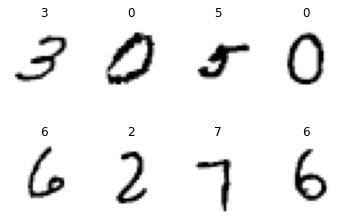

In [10]:
show_img_dataset(X, y = y, firstimg=780, nrows = 2, ncols=4, numimg=8)

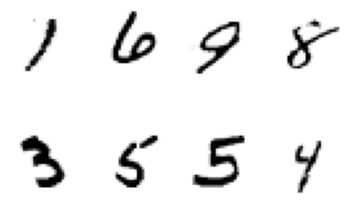

In [11]:
show_img_dataset(X_test, firstimg=780, nrows = 2, ncols=4, numimg=8)

In [12]:
#Normalizating Features and One Hot Encoding Labels. 
X = X/255
X_test = X_test/255

y = train_df['label']
y = tf.keras.utils.to_categorical(y, num_classes = 10)
X.shape, y.shape

((42000, 28, 28, 1), (42000, 10))

I use a really small validation dataset, because of the similariti of the images, it's difficult to overfit the model, but just in case I'm going to check that the overfitting is under control with this small Validation Dataset. 

In [13]:
#obtainig from X and y training and validating data. 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [14]:
#just to cleant a little bit the memory, but it's no t necessary. 
del X, y, train_df, test_df

In [15]:
#Check the shapes. 
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((35700, 28, 28, 1), (6300, 28, 28, 1), (35700, 10), (6300, 10))

## Data Augmentation
Just a little bit of DataAugmentation. 

Vertical or horizontal flips are contraproducent, but
a bit of shift and zoom helps with the final accuracy. 

In [16]:
from keras.preprocessing.image import ImageDataGenerator

x_trainr = X_train.reshape(-1, 28, 28, 1)
x_valr = X_val.reshape(-1, 28, 28, 1)

datagen = ImageDataGenerator(
        rotation_range=5, 
        zoom_range = 0.1, 
        width_shift_range=0.05, 
        height_shift_range=0.05,    
)  

X_mean = X_train.mean(axis=0)
datagen.fit(X_train - X_mean)
train_gen = datagen.flow(x_trainr, y_train, batch_size=100)
val_gen = datagen.flow(x_valr, y_val, batch_size=100)

# The Model & Callback functions
I used two callbacks. 

**ModelCheckPoint**: to save the best model and load it after the fit. Rareley the result of the last epoch is the best. In the param **monitor** you can iondicate wich value you want to watch, the default is loss, but I prefer to improve the val_accuracy. Not sure if we can get a better score in the test dataset if we get the model with the best loss value instead of the one with the best accuracy. 

**ReduceLROnPlateau**: It reduces the **learning_rate** after the **epochs** indicated when there are no improvement in the **monitor** variable indicated. We are going to train just for 30 epochs and I indicated a really short patiente of 3 **epochs**. 

Maybe it's important to mention that I replaced the Dropout layer for a SpatialDropout one. Is similar, but it affects to an entirely channel. 

**Dropout** 
[[1, 1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1]]

Transforms to: 

[[0, 1, 1, 1]
[1, 1, 0, 1]
[1, 0, 1, 1]]


**Spatial Dropout **

[[1, 1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1]]

Transforms to: 

[[1, 1, 0, 1]
[1, 1, 0, 1]
[1, 1, 0, 1]]


In [17]:
#This callback function reduces de learning rate in epochs > 20, 
#but I didn't use in the final version. 
def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.1)  

reduce_last_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [18]:
#just clean the sessio, recomendable if we execute some times the model. 
keras.backend.clear_session()

#This callback saves the best model based in val_accuracy
cpDA4 = tf.keras.callbacks.ModelCheckpoint('modelDA.h5', 
                                           mode='max', monitor='val_accuracy', 
                                           verbose=1, 
                                           save_best_only=True)

#This callback will reduce the learning rate after 3 epochs with no improvement in 
#the val_accuracy. 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                              patience=3, verbose=1, mode='auto')
#This callback reduces the lr in the last epochs, but i'm not using it by the moment. 
reduce_last_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

modelDA4 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2,2), strides=(1, 1), padding='valid'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SpatialDropout2D(0.2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2), strides=(1, 1), padding='valid'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])
modelDA4.summary()

2022-09-29 21:43:58.885258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 23, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 21, 32)        128       
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 21, 21, 32)        0

2022-09-29 21:43:58.990568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 21:43:58.991351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 21:43:58.992538: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-29 21:43:58.992829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [19]:
modelDA4.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy']) 


historyDA4 = modelDA4.fit(train_gen, 
                        steps_per_epoch=len(train_gen),
                        validation_data=val_gen,
                        validation_steps=len(val_gen), 
                        epochs=30, 
                        verbose=1, 
                        callbacks=[cpDA4, reduce_lr]
                        )

Epoch 1/30


2022-09-29 21:44:01.997138: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-29 21:44:03.878849: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


357/357 [==============================] - 20s 34ms/step - loss: 0.1888 - accuracy: 0.9426 - val_loss: 0.3083 - val_accuracy: 0.9070

Epoch 00001: val_accuracy improved from -inf to 0.90698, saving model to modelDA.h5
Epoch 2/30
357/357 [==============================] - 11s 31ms/step - loss: 0.0779 - accuracy: 0.9761 - val_loss: 0.0603 - val_accuracy: 0.9813

Epoch 00002: val_accuracy improved from 0.90698 to 0.98127, saving model to modelDA.h5
Epoch 3/30
357/357 [==============================] - 11s 31ms/step - loss: 0.0586 - accuracy: 0.9821 - val_loss: 0.0501 - val_accuracy: 0.9844

Epoch 00003: val_accuracy improved from 0.98127 to 0.98444, saving model to modelDA.h5
Epoch 4/30
357/357 [==============================] - 11s 32ms/step - loss: 0.0527 - accuracy: 0.9841 - val_loss: 0.0601 - val_accuracy: 0.9833

Epoch 00004: val_accuracy did not improve from 0.98444
Epoch 5/30
357/357 [==============================] - 11s 31ms/step - loss: 0.0453 - accuracy: 0.9857 - val_loss: 0.06

# Evaluate results

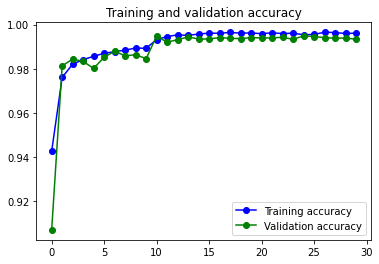

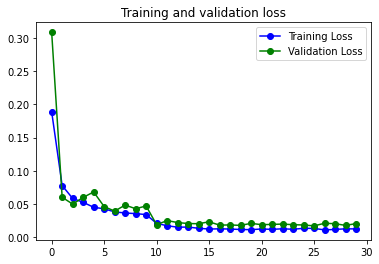

In [20]:
plot_loss_acc(historyDA4, )
modelDA_loaded = load_model('modelDA.h5')

In [21]:
prediction, results = get_predictions(modelDA_loaded, X_val, y_val)
results

,Predictions,Actuals
0,8,8
1,1,1
2,9,9
3,9,9
4,8,8
...,...,...
6295,4,4
6296,1,1
6297,6,6
6298,5,5


In [22]:
validation_loss, validation_accuracy = modelDA4.evaluate(X_val, y_val)
validation_loss_loaded, validation_accuracy_loaded = modelDA_loaded.evaluate(X_val, y_val)
print('Validation loss: ', validation_loss)
print('Validation accuracy: ', validation_accuracy)

print('Validation loss loaded: ', validation_loss_loaded)
print('Validation accuracy loaded: ', validation_accuracy_loaded)

197/197 [==============================] - 1s 3ms/step - loss: 0.0168 - accuracy: 0.9948
Validation loss:  0.016721587628126144
Validation accuracy:  0.9947618842124939
Validation loss loaded:  0.01678404211997986
Validation accuracy loaded:  0.9947618842124939


In [23]:

y_pred=modelDA_loaded.predict(X_test)
results = np.argmax(y_pred, axis=1)
results.shape, results

((28000,), array([2, 0, 9, ..., 3, 9, 2]))

In [24]:
image_id = pd.Series(range(1,28001),name='ImageId')
y_preds = pd.Series(results,name = 'Label')
pred = pd.concat([image_id,y_preds],axis=1)
pred.to_csv('submission.csv',index=False)